In [4]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


In [5]:
# !pip install catboost

In [6]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
import os

# Params

In [7]:
CAT_FEATURES = ['srch_id',
                'site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id',
                'week_id', 
#                 'season_num', 'day', 'month', 'year', 'quarter', 'week', 'dow'
               ]

# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

# drop_cols = ['usr_extra_pay']

group_col = 'srch_id'
predict_item_col = 'prop_id'
ranking_target = 'target'

In [8]:
original_cols = [
    'srch_id',
    'date_time',
    'site_id',
    'visitor_location_country_id',
    'visitor_hist_starrating',
    'visitor_hist_adr_usd',
    'prop_country_id',
    'prop_id',
    'prop_starrating',
    'prop_review_score',
    'prop_brand_bool',
    'prop_location_score1',
    'prop_location_score2',
    'prop_log_historical_price',
    'price_usd',
    'promotion_flag',
    'srch_destination_id',
    'srch_length_of_stay',
    'srch_booking_window',
    'srch_adults_count',
    'srch_children_count',
    'srch_room_count',
    'srch_saturday_night_bool',
    'srch_query_affinity_score',
    'orig_destination_distance',
    'random_bool',
    'comp1_inv',
    'comp1_rate_percent_diff',
    'comp2_inv',
    'comp2_rate_percent_diff',
    'comp3_inv',
    'comp3_rate_percent_diff',
    'comp4_inv',
    'comp4_rate_percent_diff',
    'comp5_inv',
    'comp5_rate_percent_diff',
    'comp6_inv',
    'comp6_rate_percent_diff',
    'comp7_inv',
    'comp7_rate_percent_diff',
    'comp8_inv',
    'comp8_rate_percent_diff',
]

booking_date_features = [
    'date_time_ordinal',
    'hour',
    'minute',
    'morning_booking',
    'afternoon_booking',
    'evening_booking',
    'late_evening_booking',
    'night_booking',
    'work_hour_booking',
    'lunch_booking',
    'day',
    'month',
    'year',
    'quarter',
    'week',
    'dow',
    'doy',
    'days_in_month',
    'is_weekend',
    'is_month_start',
    'is_month_end',
    'is_quarter_start',
    'is_quarter_end',
    'is_year_start',
    'is_year_end',
    'week_id',
    'season_num',
    'week_summer_index',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',
    'quarter_sin',
    'quarter_cos',
    'week_sin',
    'week_cos',
    'dow_sin',
    'dow_cos',
    'doy_sin',
    'doy_cos',
    'season_num_sin',
    'season_num_cos'
]

prop_location_score_features = [
    'prop_location_score_diff',
    'prop_location_score_diff_7',
    'prop_location_score_sum',
    'prop_location_score_sum_7',
    'prop_location_score_mul',
    'prop_location_score_diff_log',
    'prop_location_score_sum_log',
    'prop_location_score_mul_log'
]

competitor_features = [
    'higher_price_than_expedia',
    'lower_price_than_expedia',
    'same_price_as_expedia',
    'comp_num_avail',
    'ratio_of_comp_with_higher_price_than_expedia',
    'ratio_of_comp_with_lower_price_than_expedia',
    'comp1_rate_percent_diff_signed',
    'comp2_rate_percent_diff_signed',
    'comp3_rate_percent_diff_signed',
    'comp4_rate_percent_diff_signed',
    'comp5_rate_percent_diff_signed',
    'comp6_rate_percent_diff_signed',
    'comp7_rate_percent_diff_signed',
    'comp8_rate_percent_diff_signed',
    'comp1_rate_percent_diff_log_2',
    'comp1_rate_percent_diff_log_10',
    'comp2_rate_percent_diff_log_2',
    'comp2_rate_percent_diff_log_10',
    'comp3_rate_percent_diff_log_2',
    'comp3_rate_percent_diff_log_10',
    'comp4_rate_percent_diff_log_2',
    'comp4_rate_percent_diff_log_10',
    'comp5_rate_percent_diff_log_2',
    'comp5_rate_percent_diff_log_10',
    'comp6_rate_percent_diff_log_2',
    'comp6_rate_percent_diff_log_10',
    'comp7_rate_percent_diff_log_2',
    'comp7_rate_percent_diff_log_10',
    'comp8_rate_percent_diff_log_2',
    'comp8_rate_percent_diff_log_10',
]

price_features = [
    'price_per_day',
    'price_per_trip',
    'price_usd_pow_0.33',
    'price_usd_pow_0.5',
    'price_usd_pow_2',
    'price_usd_log_2',
    'price_usd_log_10',
    'price_usd_log_2.72',
    'price_usd_reciprocal',
    'price_per_trip_pow_0.33',
    'price_per_trip_pow_0.5',
    'price_per_trip_pow_2',
    'price_per_trip_log_2',
    'price_per_trip_log_10',
    'price_per_trip_log_2.72',
    'price_per_trip_reciprocal',
]

historical_price_features = [
    'visitor_hist_adr_usd_pow_0.33',
    'visitor_hist_adr_usd_pow_0.5',
    'visitor_hist_adr_usd_pow_2',
    'visitor_hist_adr_usd_log_2',
    'visitor_hist_adr_usd_log_10',
    'visitor_hist_adr_usd_log_2.72',
    'visitor_hist_adr_usd_reciprocal',
    'prop_log_historical_price_pow_0.33',
    'prop_log_historical_price_pow_0.5',
    'prop_log_historical_price_pow_2',
    'prop_log_historical_price_log_2',
    'prop_log_historical_price_log_10',
    'prop_log_historical_price_log_2.72',
    'prop_log_historical_price_reciprocal',
    'price_diff_to_usr_hist',
    'price_ratio_to_usr_hist',
    'price_diff_to_place_hist_price',
    'place_hist_price_diff_usr_hist',
]

trip_detail_features = [
    'travel_inside',
    'trans_ocean',
    'booking_weeks_ahead',
    'booking_months_ahead',
    'len_of_stay_to_booking_ahead_ratio',
    'len_of_stay_to_booking_ahead_diff',
    'srch_length_of_stay_in_weeks',
    'date',
    'trip_start_date',
    'trip_end_date',
    'holidays_during_trip',
    'business_trip',
    'children_per_adult',
    'total_people',
    'people_per_room',
    'separate_children_room'
]

aggregate_features = [
    'price_index_per_srch_id',
    'price_index_per_srch_destination_id',
    'price_index_per_prop_id',
    'mean_click_bool_per_prop_id',
    'mean_booking_bool_per_prop_id',
    'mean_srch_query_affinity_score',
    'mean_position_per_prop_id',
]

uncategorized_features = [
    'was_sold_in_that_period',
    'srch_query_affinity_score_prob'
]

# Read data

In [9]:
data_path = 'data'

In [10]:
import pickle5 as pickle
def read_pickled_df(path):
    with open(path, "rb") as fh:
        df = pickle.load(fh)
    return df

X_train = read_pickled_df(os.path.join(data_path, 'X_train.pickle')).reset_index(drop=True)
y_train = read_pickled_df(os.path.join(data_path, 'y_train.pickle')).reset_index(drop=True)


# X_train = pd.read_pickle(os.path.join(data_path, 'X_train.pickle'))
# y_train = pd.read_pickle(os.path.join(data_path, 'y_train.pickle'))

print('X_train.shape', X_train.shape)
X_train.head()

X_train.shape (3969251, 181)


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_inv,comp1_rate_percent_diff,comp2_inv,comp2_rate_percent_diff,comp3_inv,comp3_rate_percent_diff,comp4_inv,comp4_rate_percent_diff,comp5_inv,comp5_rate_percent_diff,comp6_inv,comp6_rate_percent_diff,comp7_inv,comp7_rate_percent_diff,comp8_inv,comp8_rate_percent_diff,was_sold_in_that_period,date_time_ordinal,hour,minute,morning_booking,afternoon_booking,evening_booking,late_evening_booking,night_booking,work_hour_booking,lunch_booking,day,month,year,quarter,week,dow,doy,days_in_month,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,week_id,season_num,week_summer_index,day_sin,day_cos,month_sin,month_cos,quarter_sin,quarter_cos,week_sin,week_cos,dow_sin,dow_cos,doy_sin,doy_cos,season_num_sin,season_num_cos,trans_ocean,prop_location_score_diff,prop_location_score_diff_7,prop_location_score_sum,prop_location_score_sum_7,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,travel_inside,higher_price_than_expedia,lower_price_than_expedia,same_price_as_expedia,comp_num_avail,ratio_of_comp_with_higher_price_than_expedia,ratio_of_comp_with_lower_price_than_expedia,comp1_rate_percent_diff_signed,comp2_rate_percent_diff_signed,comp3_rate_percent_diff_signed,comp4_rate_percent_diff_signed,comp5_rate_percent_diff_signed,comp6_rate_percent_diff_signed,comp7_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day,price_per_trip,price_usd_pow_0.33,price_usd_pow_0.5,price_usd_pow_2,price_usd_log_2,price_usd_log_10,price_usd_log_2.72,price_usd_reciprocal,visitor_hist_adr_usd_pow_0.33,visitor_hist_adr_usd_pow_0.5,visitor_hist_adr_usd_pow_2,visitor_hist_adr_usd_log_2,visitor_hist_adr_usd_log_10,visitor_hist_adr_usd_log_2.72,visitor_hist_adr_usd_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_pow_0.5,prop_log_historical_price_pow_2,prop_log_historical_price_log_2,prop_log_historical_price_log_10,prop_log_historical_price_log_2.72,prop_log_historical_price_reciprocal,price_per_trip_pow_0.33,price_per_trip_pow_0.5,price_per_trip_pow_2,price_per_trip_log_2,price_per_trip_log_10,price_per_trip_log_2.72,price_per_trip_reciprocal,comp1_rate_percent_diff_log_2,comp1_rate_percent_diff_log_10,comp2_rate_percent_diff_log_2,comp2_rate_percent_diff_log_10,comp3_rate_percent_diff_log_2,comp3_rate_percent_diff_log_10,comp4_rate_percent_diff_log_2,comp4_rate_percent_diff_log_10,comp5_rate_percent_diff_log_2,comp5_rate_percent_diff_log_10,comp6_rate_percent_diff_log_2,comp6_rate_percent_diff_log_10,comp7_rate_percent_diff_log_2,comp7_rate_percent_diff_log_10,comp8_rate_percent_diff_log_2,comp8_rate_percent_diff_log_10,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,place_hist_price_diff_usr_hist,booking_weeks_ahead,booking_months_ahead,len_of_stay_to_booking_ahead_ratio,len_of_stay_to_booking_ahead_diff,srch_length_of_stay_in_weeks,date,trip_start_date,trip_end_date,holidays_during_trip,business_trip,children_per_adult,total_people,people_per_room,separate_children_room,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,mean_click_bool_per_prop_id,mean_booking_bool_per_prop_id,mean_srch_query_affinity_score,mean_position_per_prop_id,srch_query_affinity_score_prob
28,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,3625,4.0,4.0,0,3.22,0.2544,5.98,295.0,0,12588,2,46,1,0,1,1,NaN,238.350006,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,76234,8,59,True,False,False,False,False,True,Fals

In [11]:
# makes sure all features are categorized
assert set() == set(X_train.columns) - set(original_cols + booking_date_features + prop_location_score_features + competitor_features + price_features + historical_price_features + trip_detail_features + aggregate_features + uncategorized_features)

In [7]:
X_train.dtypes.value_counts()#.apply(lambda x: x.name).to_dict()

float32    105
uint8       30
bool        11
uint32       4
uint16       4
int8         4
int16        1
dtype: int64

In [8]:
train_pool = Pool(data=X_train, 
                  label=y_train,
                  group_id=X_train[group_col],
                  cat_features=CAT_FEATURES,
                  )
del X_train, y_train; gc.collect()

In [9]:
X_val = read_pickled_df(os.path.join(data_path, 'X_val.pickle')).reset_index(drop=True)
y_val = read_pickled_df(os.path.join(data_path, 'y_val.pickle')).reset_index(drop=True)

print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

del X_val, y_val; gc.collect()

# Cross-validation

In [10]:
# %%time

# params = {
#     "iterations": 1000,
#     #           'loss_function': 'NDCG:top=5',
#     'loss_function': 'QueryRMSE',
#     'custom_metric': [
#         'NDCG:top=5;type=Base;denominator=LogPosition'
#         #                       , 'PFound', 'AverageGain:top=10'
#     ],
#     "verbose": False,
#     'early_stopping_rounds': 50,
#     #     'logging_level': 'Silent',
# }

# cv_results, fitted_models = cv(train_pool, params, nfold=3, type='TimeSeries', plot=True,
#                                return_models=True)

In [11]:
# cv_results

In [12]:
# model = fitted_models[-1]

In [13]:
# import matplotlib.pyplot as plt

# for method in ['LossFunctionChange', 'PredictionValuesChange']:
#     fi = model.get_feature_importance(test_pool, type=method)
#     feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
#                                      columns=['Feature', 'Score'])

#     feature_score = feature_score_raw.sort_values(
#         by='Score', ascending=False)

#     plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
#     ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
#     ax.set_title("Feature Importance using {}".format(method), fontsize=14)
#     ax.set_xlabel("features")
#     ax.invert_yaxis()
#     plt.show()

In [14]:
# model.get_all_params()

# Fit final model

In [95]:
import catboost
catboost.__version__

'1.0.5'

In [114]:
params = {
    "iterations": 2500, # make 1500
    'loss_function': 'YetiRank', # YetiRankPairwise
#     'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition;hints=skip_train~false'], # :
    "verbose": False,
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'metric_period': 50,
#     "task_type": "GPU",
}

In [115]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=False, verbose_eval=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [84]:
model.get_best_score()

{'learn': {'MAP:top=5': 0.802272212736969},
 'validation': {'NDCG:type=Base': 0.5080680526414517,
  'NDCG:top=5;type=Base': 0.38205417289033233,
  'MAP:top=5': 0.32370442903236707}}

# Eval

In [ ]:
print(model.eval_metrics(val_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))
del val_pool; gc.collect()

In [ ]:
print(model.eval_metrics(train_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))

del train_pool; gc.collect()

In [85]:
X_test = read_pickled_df(os.path.join(data_path, 'X_test.pickle')).reset_index(drop=True)
y_test = read_pickled_df(os.path.join(data_path, 'y_test.pickle')).reset_index(drop=True)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=X_test[group_col],
    cat_features=CAT_FEATURES,
)

print(model.eval_metrics(test_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))
del test_pool, X_test, y_test; gc.collect()

In [36]:
# model.plot_tree(
#     tree_idx=0,
#     pool=val_pool
# )

# Retrain the model on train+val, with test set as eval. The hyper parameters are frozen!

# Make preds

In [ ]:
def predict_in_format(model, data, pool, group_col, predict_item_col, gt_col=None):
    preds = model.predict(pool)

    values = {group_col: data[group_col],
              predict_item_col: data[predict_item_col],
              'pred': preds}

    values_df = pd.DataFrame(values)
    values_df.sort_values(by=[group_col, 'pred'], ascending=[True, False], inplace=True)

    if gt_col is not None:
        values_df['gt'] = gt_col
        ndcg_score = values_df.groupby(group_col)['gt'].apply(ndcg, at=5).mean()
        print('Local test NDCG@5:', ndcg_score)

    return values_df

In [107]:
subm_df = pd.read_pickle(os.path.join(data_path, 'submission_df_preprocessed.pickle'))
subm_df.sort_values([group_col], inplace=True)

In [106]:
subm_name = './submission_11.csv'

In [108]:
subm_pool = Pool(
    data=subm_df,
    group_id=subm_df[group_col],
    cat_features=CAT_FEATURES,
)

output_df = predict_in_format(model, subm_df, subm_pool, group_col, predict_item_col)
del subm_df, subm_pool; gc.collect()
output_df.head(10)

,srch_id,prop_id,pred
23,1,99484,-2.568297
9,1,54937,-2.758494
5,1,28181,-2.821672
12,1,61934,-2.997627
4,1,24194,-3.245924
1,1,5543,-3.303592
6,1,34263,-3.323924
13,1,63894,-3.358774
18,1,82231,-3.385176
16,1,74045,-3.390714


In [110]:
output_df[[group_col, 'prop_id']].to_csv(subm_name, index=False)
del output_df; gc.collect()
pd.read_csv(subm_name, nrows=10)

,srch_id,prop_id
0,1,99484
1,1,54937
2,1,28181
3,1,61934
4,1,24194
5,1,5543
6,1,34263
7,1,63894
8,1,82231
9,1,74045


In [111]:
# # use locally or if you added the sample subm file to the dataset
# def validate_submission(subm_sample_path, our_subm_path):
    
#     subm_sample = pd.read_csv(subm_sample_path)
#     our_subm = pd.read_csv(our_subm_path)
    
#     assert subm_sample.shape == our_subm.shape
#     assert our_subm[group_col].equals(submission_sample_df[group_col])
#     assert our_subm.index.equals(submission_sample_df.index)
#     assert submission_sample_df.groupby(group_col)['prop_id'].apply(len).to_frame().equals(
#         our_subm.groupby(group_col)['prop_id'].apply(len).to_frame())
    
# validate_submission(os.path.join(data_path, 'submission_sample.csv'),
#                     subm_name)

# Feature importance

In [ ]:
X_test = read_pickled_df(os.path.join(data_path, 'X_test.pickle')).reset_index(drop=True)
y_test = read_pickled_df(os.path.join(data_path, 'y_test.pickle')).reset_index(drop=True)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=X_test[group_col],
    cat_features=CAT_FEATURES,
)

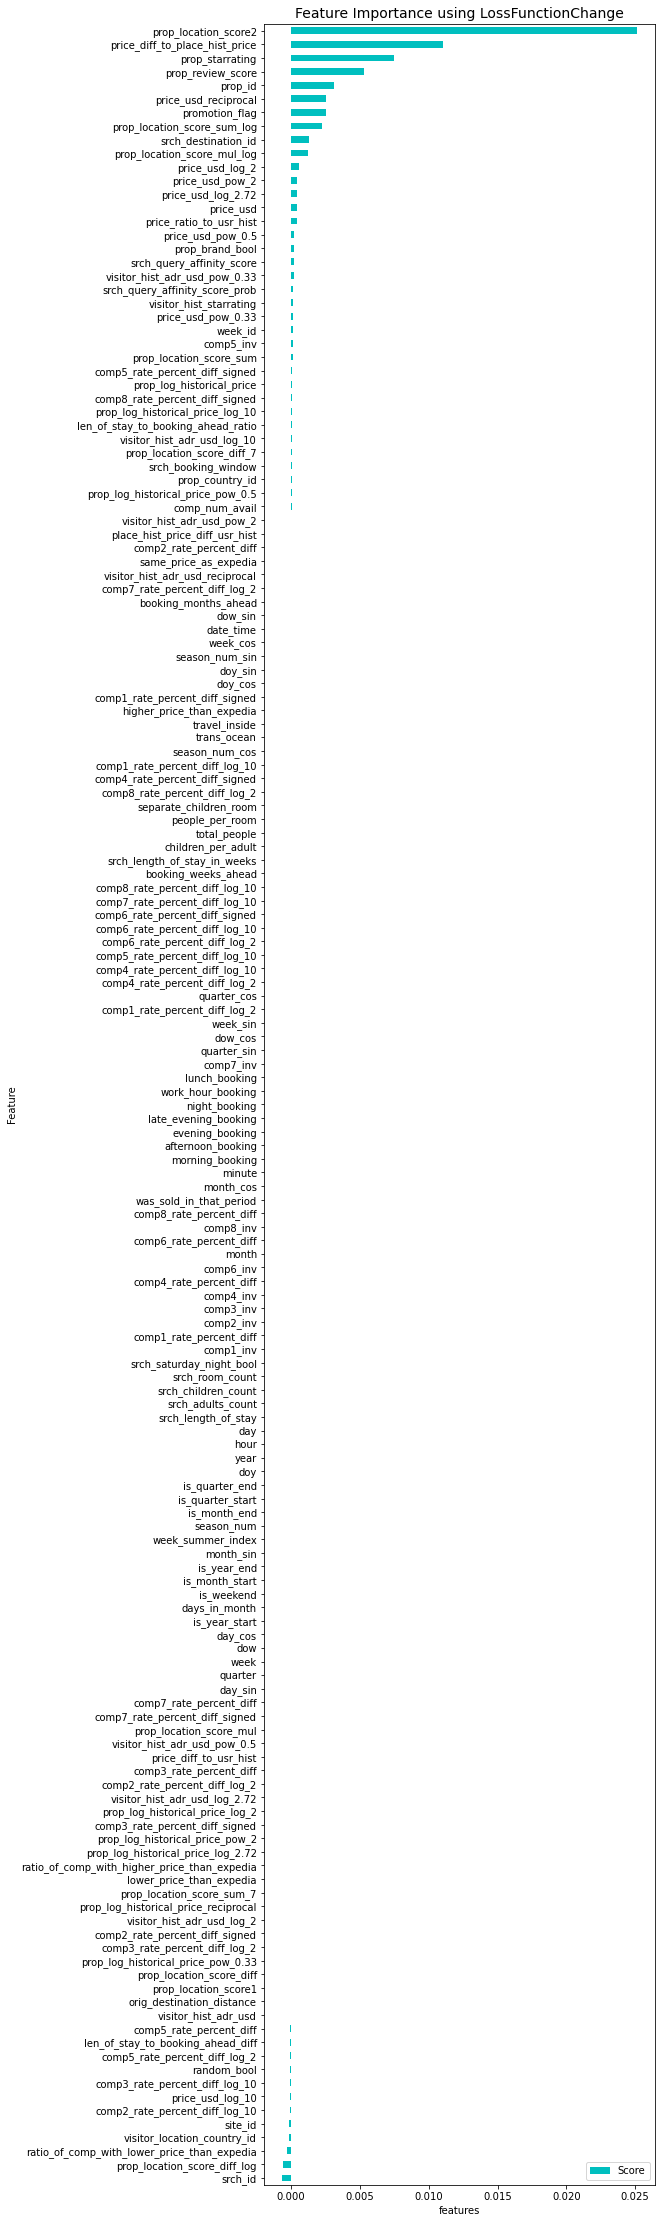

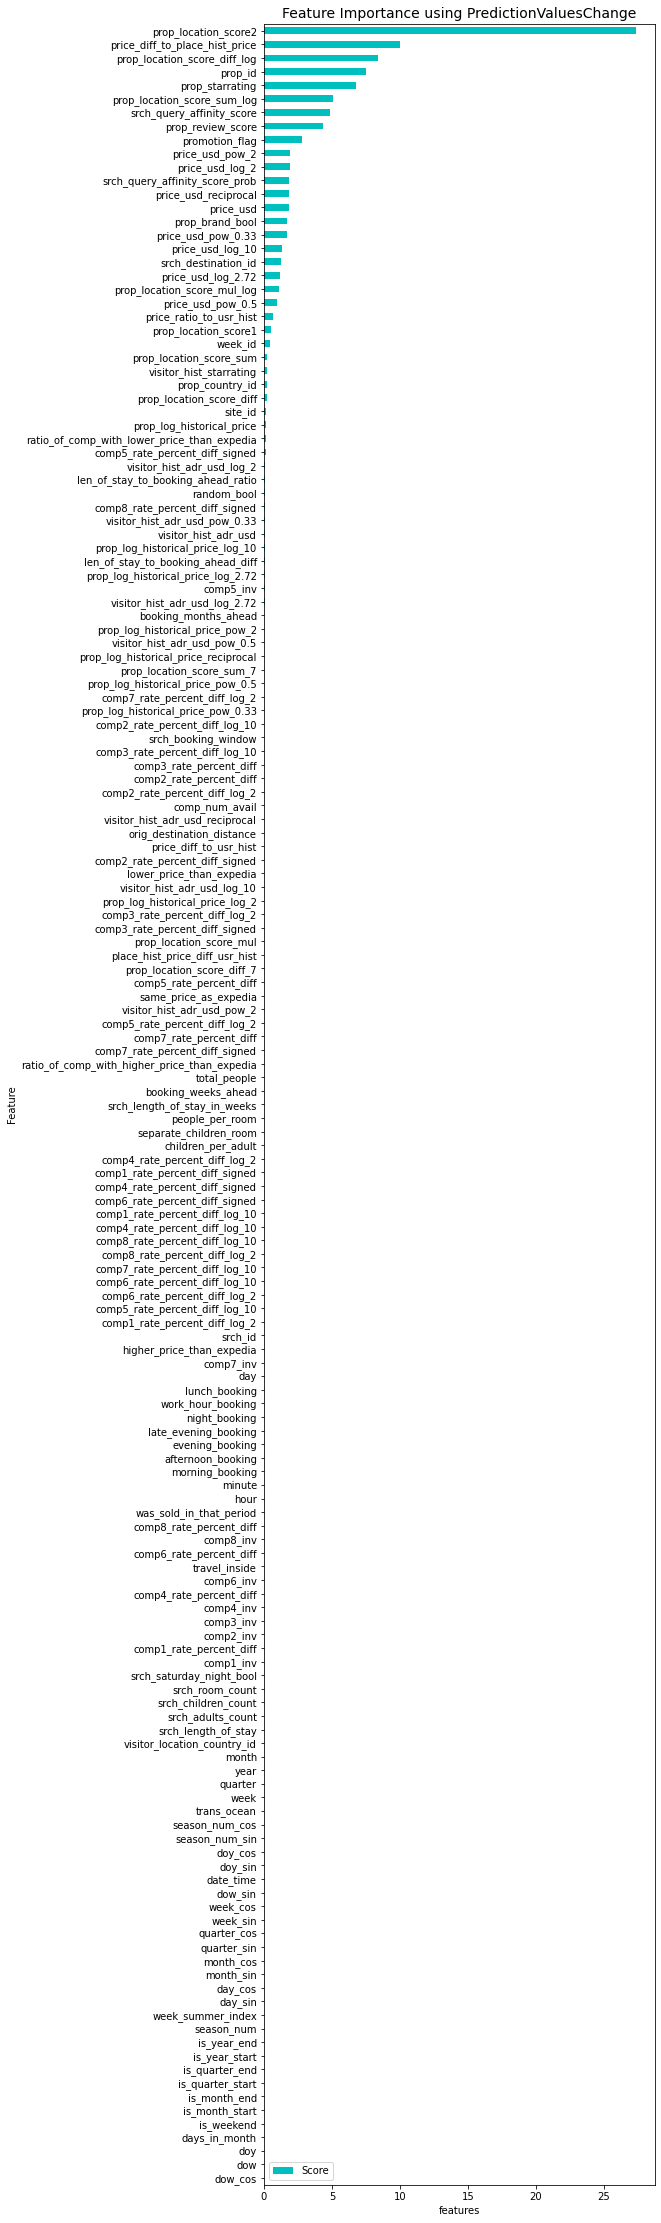

In [105]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange', 'PredictionValuesChange']:
    fi = model.get_feature_importance(test_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

In [ ]:
# from feature_importance import get_and_plot_feature_imp_catboost
# feature_score_SHAP, shap_values_raw = get_and_plot_feature_imp_catboost(model, X_val, y_val,
#                                                                             method='SHAP',
#                                                                             cat_features=CAT_FEATURES,
#                                                                             #                                                        plot_type='bar',
#                                                                             top_n=COLLECT_N_IMPORTANT_FEATURES)

#     important_features_collected.update(feature_score_SHAP.sort_values(
#         ['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

In [ ]:
# feature_score_PredictionValuesChange = get_and_plot_feature_imp_catboost(
#         model, X_val, y_val,
#         cat_features=CAT_FEATURES,
#         method='PredictionValuesChange',
#         top_n=COLLECT_N_IMPORTANT_FEATURES)

#     important_features_collected.update(feature_score_PredictionValuesChange.sort_values(['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])